In [1]:
import copy
import lmfit
import logging
import inspect
import warnings
import operator
import textwrap
import numpy as np
import functools as ft
import matplotlib.pyplot as plt

In [2]:
def _index_range_of_array(arrval, minval, maxval):
    """
    Return the index of array elements within a specified range [minval, maxval].
    """
    indices = np.where((arrval >= minval) & (arrval <= maxval))[0]
    return indices if indices.size > 0 else None


def print_in_box(expr, line_style='#', width=80):
    """
    Print a string inside a box, wrapping lines so they fit within `width`.

    Parameters
    ----------
    expr : str
        The expression string to print.
    line_style : str, optional
        Character(s) used for the box border (default='*').
    width : int, optional
        Maximum width of the box (default=80).
    """
    # Wrap the text to the given width
    wrapped_lines = textwrap.wrap(expr, width=width-4)  # leave space for borders

    # Determine box width
    box_width = max(len(line) for line in wrapped_lines) + 4

    # Top border
    print(line_style * box_width)

    # Each line with padding, using line_style for sides
    for line in wrapped_lines:
        print(f"{line_style} {line.ljust(box_width-4)} {line_style}")

    # Bottom border
    print(line_style * box_width)


def evaluate_function(function, xdat, params, prefix, i, kws=None):
    """
    Evaluate a single function with parameters from lmfit and fixed options.

    Parameters
    ----------
    function : callable
        The function to evaluate (e.g. gaussian, exponential).
    xdat : array-like
        Input x data.
    params : lmfit.Parameters
        Composite parameter set containing prefixed parameter names.
    prefix : str
        Prefix for this function (e.g. 'c0_', 'c1_').
    i : int
        Index for dataset (e.g. 0 for first dataset).
    kws : dict, optional
        Fixed options (non-fit parameters like form='erf', gamma=5.0).

    Returns
    -------
    ndarray
        Evaluated function values.
    """
    if kws is None:
        kws = {}

    # Get ordered function parameters
    fn_pars = list(inspect.signature(function).parameters.keys())

    # First parameter is the x variable name
    xname = fn_pars[0]

    # Remaining parameters
    argnames = fn_pars[1:]

    kwargs = {}
    for name in argnames:
        # Case 1: name is in lmfit parameter set → pull from params
        param_key = f"{prefix}{name}_{i}"
        if param_key in params:
            kwargs[name] = params[param_key].value

        # Case 2: name is in extra kwargs (fixed parameters)
        elif name in kws:
            kwargs[name] = kws[name]

        # Case 3: leave it alone; function will handle default value
        else:
            pass

    # Evaluate function safely
    return function(xdat, **kwargs)
    

In [3]:
"""Basic model lineshapes and distribution functions."""

from numpy import (arctan, copysign, cos, exp, isclose, isnan, log, log1p,
                   maximum, minimum, pi, real, sign, sin, sqrt, where)
from scipy.special import betaln as betalnfcn
from scipy.special import erf, erfc
from scipy.special import gamma as gamfcn
from scipy.special import loggamma as loggammafcn
from scipy.special import wofz

log2 = log(2)
s2pi = sqrt(2*pi)
s2 = sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

functions = ('gaussian', 'gaussian2d', 'lorentzian', 'voigt',
             'pvoigt', 'moffat', 'pearson4', 'pearson7',
             'breit_wigner', 'damped_oscillator', 'dho', 'logistic',
             'lognormal', 'students_t', 'expgaussian', 'doniach',
             'skewed_gaussian', 'skewed_voigt',
             'thermal_distribution', 'bose', 'fermi', 'step',
             'rectangle', 'exponential', 'powerlaw', 'linear',
             'parabolic', 'sine', 'expsine', 'split_lorentzian')


import os
import lmfit
import operator
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(copysign(max(tiny, abs(value)), value))


def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


def exponential(x, amplitude=1, decay=1):
    """Return an exponential function.

    exponential(x, amplitude, decay) = amplitude * exp(-x/decay)

    """
    decay = not_zero(decay)
    return amplitude * exp(-x/decay)


def lorentzian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Lorentzian function.

    lorentzian(x, amplitude, center, sigma) =
        (amplitude/(1 + ((1.0*x-center)/sigma)**2)) / (pi*sigma)

    """
    return ((amplitude/(1 + ((1.0*x-center)/max(tiny, sigma))**2))
            / max(tiny, (pi*sigma)))


def powerlaw(x, amplitude=1, exponent=1.0):
    """Return the powerlaw function.

    powerlaw(x, amplitude, exponent) = amplitude * x**exponent

    """
    return amplitude * x**exponent


def linear(x, slope=1.0, intercept=0.0):
    """Return a linear function.

    linear(x, slope, intercept) = slope * x + intercept

    """
    return slope * x + intercept


def voigt(x, amplitude=1.0, center=0.0, sigma=1.0, gamma=None):
    """Return a 1-dimensional Voigt function.

    voigt(x, amplitude, center, sigma, gamma) =
        amplitude*real(wofz(z)) / (sigma*s2pi)

    For more information, see: https://en.wikipedia.org/wiki/Voigt_profile

    """
    if gamma is None:
        gamma = sigma
    z = (x-center + 1j*gamma) / max(tiny, (sigma*s2))
    return amplitude*real(wofz(z)) / max(tiny, (sigma*s2pi))


def step(x, amplitude=1.0, center=0.0, sigma=1.0, form='linear'):
    """Return a step function.

    Starts at 0.0, ends at `sign(sigma)*amplitude`, has a half-max at
    `center`, rising or falling with `form`:

    - `'linear'` (default) = amplitude * min(1, max(0, arg + 0.5))
    - `'atan'`, `'arctan'` = amplitude * (0.5 + atan(arg)/pi)
    - `'erf'`              = amplitude * (1 + erf(arg))/2.0
    - `'logistic'`         = amplitude * [1 - 1/(1 + exp(arg))]

    where ``arg = (x - center)/sigma``.

    Note that ``sigma > 0`` gives a rising step, while ``sigma < 0`` gives
    a falling step.
    """
    out = sign(sigma)*(x - center)/max(tiny*tiny, abs(sigma))

    if form == 'erf':
        out = 0.5*(1 + erf(out))
    elif form == 'logistic':
        out = 1. - 1./(1. + exp(out))
    elif form in ('atan', 'arctan'):
        out = 0.5 + arctan(out)/pi
    elif form == 'linear':
        out = minimum(1, maximum(0, out + 0.5))
    else:
        msg = (f"Invalid value ('{form}') for argument 'form'; should be one "
               "of 'erf', 'logistic', 'atan', 'arctan', or 'linear'.")
        raise ValueError(msg)

    return amplitude*out


def rectangle(x, amplitude=1.0, center1=0.0, sigma1=1.0,
              center2=1.0, sigma2=1.0, form='linear'):
    """Return a rectangle function: step up, step down.
    Starts at 0.0, rises to `amplitude` (at `center1` with width `sigma1`),
    then drops to 0.0 (at `center2` with width `sigma2`) with `form`:
    - `'linear'` (default) = ramp_up + ramp_down
    - `'atan'`, `'arctan`' = amplitude*(atan(arg1) + atan(arg2))/pi
    - `'erf'`              = amplitude*(erf(arg1) + erf(arg2))/2.
    - `'logisitic'`        = amplitude*[1 - 1/(1 + exp(arg1)) - 1/(1+exp(arg2))]

    where ``arg1 = (x - center1)/sigma1`` and ``arg2 = -(x - center2)/sigma2``.

    Note that, unlike `step`,  ``sigma1 > 0`` and ``sigma2 > 0``, so that a
    rectangle can support a step up followed by a step down.
    Use a constant offset and adjust amplitude if that is what you need.

    See Also
    --------
    step

    """
    arg1 = (x - center1)/max(tiny, sigma1)
    arg2 = (center2 - x)/max(tiny, sigma2)

    if form == 'erf':
        out = 0.5*(erf(arg1) + erf(arg2))
    elif form == 'logistic':
        out = 1. - 1./(1. + exp(arg1)) - 1./(1. + exp(arg2))
    elif form in ('atan', 'arctan'):
        out = (arctan(arg1) + arctan(arg2))/pi
    elif form == 'linear':
        out = 0.5*(minimum(1, maximum(-1, arg1)) + minimum(1, maximum(-1, arg2)))
    else:
        msg = (f"Invalid value ('{form}') for argument 'form'; should be one "
               "of 'erf', 'logistic', 'atan', 'arctan', or 'linear'.")
        raise ValueError(msg)

    return amplitude*out

In [ ]:
class LmfitGlobal:
    _valid_connector_lst = ('+', '-', '*', '/')
    _valid_connector_dict = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul,
        '/': operator.truediv,
    }


    @staticmethod
    def what():
        return 

    def __init__(self, items, independent_vars=None, nan_policy='raise', **kws):
        """This create lmfit-global function from user-supplied model function. 

        Args:
            items (dict): Dictionary to define model problem. See documentations
            independent_vars (:obj:`list` of :obj:`str`, optional): Arguments to `func` that are independent variables 
                (default is None).
            nan_policy ({'raise', 'propagate', 'omit'}, optional): How to handle NaN and missing values 
                in data. See Notes below.
            prefix (str, optional) : Prefix used for the model. Default will be created with `index`
            **kws (dict, optional): Additional keyword arguments to pass to model function.

            Notes
            -----
            1. The model function must return an array that will be the same
            size as the data being modeled.

            2. Parameter names are inferred from the function arguments by default,
            and a residual function is automatically constructed.

            3. Specifying `independent_vars` here will explicitly name the
            independent variables for the Model.  in contrast, `param_names` is
            meant to help infer Parameter names for keyword arguments defined with
            ``**kws`` in the Model function.

            4. `nan_policy` sets what to do when a NaN or missing value is
            seen in the data. Should be one of:

            - `'raise'` : raise a `ValueError` (default)
            - `'propagate'` : do nothing
            - `'omit'` : drop missing data

        Returns:
            _type_: _description_
        """
        # for key, val in kws.items():
        #     setattr(self, key, val)

        self.options = kws
        
        # Make own copy to avoid overwriting of internal elements
        items = copy.deepcopy(items)

        # -- Extract and validate data info
        data = items.get('data', None)
        # --- validataion ---
        if data is None:
            raise ValueError(f'Raw data needed for fit')
        
        # self.data_x = data.get('data_x', None)
        # self.data_y = data.get('data_y', None)
        # if self.data_x is None:
        #     raise ValueError(f'Raw x-data needed for fit')
        # if self.data_y is None:
        #     raise ValueError(f'Raw y-data needed for fit')
        
        # self.data_x = self.ensure_2darray(self.data_x)
        # self.data_y = self.ensure_2darray(self.data_y)

        self.data = data
        # self.data_xy = self.data.get('data_xy', None) # deprecated
        self.data_xy = self.data.get('xy', None) 
        # --- validataion ---
        if self.data_xy is None:
            raise ValueError(f'Raw x-y data needed for fit')
        # --- enusure it is 2D
        if np.asarray(self.data_xy).ndim !=2:
            raise ValueError('We expect x-y data to be 2D array')
        # --- extract x-data as 1 dim array and y-data as 2 dim array
        self.data_x = self.data_xy[:,0]
        self.data_y = self.data_xy[:,1:]

        # --- extract number of dataset ny and length N of each dataset
        self.N, self.ny = self.data_y.shape

        # I BELIEVE THIS PART SHOULD BE IN FIT/THEORY PART
        # TO CHECK LATER 
        # --- get x data range to fit
        self.data_xrange = self.data.get('xrange', None) 
        # --- validation ---
        if self.data_xrange is not None:
            if not self.data_xrange:  # catches [], (), '', 0, False
                raise ValueError(f'`data_xrange` cannot be empty')
            if (
                not isinstance(self.data_xrange, (list, tuple)) or len(self.data_xrange)!=2 or 
                not all(isinstance(xr, (int, float)) for xr in self.data_xrange)
            ):
                raise ValueError(
                    f'`data_xrange` must be a list/tuple of two numbers, got: {self.data_xrange}'
                    ) 
        # --- extract x-y raw data to be fitted if fit range is giving
        self.xdat = self.data_x
        self.ydat = self.data_y
        if self.data_xrange:
            idx = _index_range_of_array(self.data_x, minval=self.data_xrange[0], maxval=self.data_xrange[1])
            self.xdat = np.take(self.data_x, idx)          # the range data we are interested to fit
            self.ydat = np.take(self.data_y, idx, axis=0)  # the range data we are interested to fit

        # --- Handle Theory/Function info
        self._prefix_on=False
        # -- Extract and validate functions info
        functions = items.get('functions', None)
        # --- validataion ---
        if functions is None:
            raise ValueError(f'Theory/Functions needed for fit')
        self.functions = functions

        # --- Retrieve theory functions ---
        self.theory = self.functions.get('theory', None)
        # --- validataion ---
        if self.theory is None:
            raise ValueError(f'Fit Functions (`theory`) are required for fitting...')
        # --- Count number of components ---
        self.nc = len(self.theory)
        # --- Retrieve connector list ---
        self.theory_connector_lst = self.functions.get('theory_connectors', None)
        self.theory_connector_list = copy.deepcopy(self.theory_connector_lst)
        # --- Validate connector list only if multiple components ---
        if self.nc > 1:
            self._prefix_on=True
            if self.theory_connector_lst is None:
                raise ValueError(f'Missing `theory_connectors` list — required to combine multiple theory functions.')
            if not isinstance(self.theory_connector_lst, list):
                raise TypeError(f'`theory_connectors` must be a list, got {type(self.theory_connector_lst).__name__}')
            if not all(isinstance(op, str) and op in self._valid_connector_lst for op in self.theory_connector_lst):
                raise ValueError(f'`theory_connectors` must contain only arithmetic operators: {sorted(self._valid_connector_lst)}')
            if len(self.theory_connector_lst) != self.nc - 1:
                raise ValueError(f'Expected {self.nc - 1} connectors for {self.nc} theory functions, got {len(self.theory_connector_lst)}')
        else:
            self._prefix_on=False
            # For single function, connector list must be None or empty
            if self.theory_connector_lst not in (None, [], ()):
                raise ValueError(f'`theory_connectors` must be None or empty when only one theory function is provided.')
            # self.theory_connector_lst = None


        # for i, theory_entry in enumerate(self.theory):
        #     func = theory_entry.get('func_name', None)
        #     if func is None:
        #         raise ValueError(f'Missing or invalid `"func_name"` in theory[{i}] — each entry must define a callable under the key `"func_name"`.')
        #     self.func_lst.append(func)
        #     self.funcname_lst.append(func.__name__)

        # # --- Extract independent variable parameter
        # # --- By DEFAULT, the first argument of the (ANY) function is taken as the independent variable, held in independent_vars, 
        # # --- and the rest of the functions positional arguments are used for Parameter names. 
        # self.independent_vars = independent_vars
        # parnames = list(inspect.signature(self.func_lst[0]).parameters.keys())
        # if self.independent_vars is None:
        #     self.independent_vars = parnames[0]

        self.nan_policy = nan_policy
        # -- Check of the the raw data to fit has NaNs
        self.has_nan = np.isnan(self.ydat).any()

        self.nan_policy = nan_policy
        # -- Check of the the raw data to fit has NaNs
        self.has_nan = np.isnan(self.ydat).any()

        # -- Raise error if NaNs are found and policy is 'raise'
        if self.has_nan and self.nan_policy == 'raise':
            raise ValueError(
                f'Detected NaN values in `ydat`, but `nan_policy="raise"` is active.\n'
                'Please clean your data or choose a different `nan_policy`:\n'
                '  - "omit"     → automatically exclude NaN-containing points from the fit\n'
                '  - "propagate"→ allow NaNs to pass through (may result in NaN outputs)\n'
                '  - "raise"    → (default) stop and alert if any NaNs are present'
            )

            
        # --- Extract and validate function paraameter list ---
        self.func_lst = []
        self.funcname_lst = []
        self.model_lst = []
        self.independent_vars = independent_vars
        self.xpar = None
        self.indep_vars = None   # updated or last independent variable
        self.independent_vars_lst = []
        self.extra_model_lst_kwargs = []
        self.prefix_lst = []

        # --- Initial model to create model list ---
        self._create_model_list()

        self.func_list = copy.deepcopy(self.func_lst)
        self.funcname_list = copy.deepcopy(self.funcname_lst)
        self.model_list = copy.deepcopy(self.model_lst)
        self.independent_vars = self.indep_vars
        self.independent_vars_list = copy.deepcopy(self.independent_vars_lst)
        self.extra_model_list_kwargs = copy.deepcopy(self.extra_model_lst_kwargs)
        self.prefix_list = copy.deepcopy(self.prefix_lst)

        # --- Build initial parameters ---
        self._initial_params = lmfit.Parameters()
        self._build_init_params()
        # --- Initiate program ---
        self.rss = []
        self._eval()
        self.plot()
        #
        #
        #


    # def _validate(self):
    #     """ Extract and validate data info
    #     """
    #     # -- Extract and validate data info
    #     data = self.items.get('data', None)
    #     # --- validataion ---
    #     if data is None:
    #         raise ValueError(f'Raw data needed for fit')
        
    #     # self.data_x = data.get('data_x', None)
    #     # self.data_y = data.get('data_y', None)
    #     # if self.data_x is None:
    #     #     raise ValueError(f'Raw x-data needed for fit')
    #     # if self.data_y is None:
    #     #     raise ValueError(f'Raw y-data needed for fit')
        
    #     # self.data_x = self.ensure_2darray(self.data_x)
    #     # self.data_y = self.ensure_2darray(self.data_y)

    #     self.data = data
    #     # self.data_xy = self.data.get('data_xy', None) # deprecated
    #     self.data_xy = self.data.get('xy', None) 
    #     # --- validataion ---
    #     if self.data_xy is None:
    #         raise ValueError(f'Raw x-y data needed for fit')
    #     # --- enusure it is 2D
    #     if np.asarray(self.data_xy).ndim !=2:
    #         raise ValueError('We expect x-y data to be 2D array')
    #     # --- extract x-data as 1 dim array and y-data as 2 dim array
    #     self.data_x = self.data_xy[:,0]
    #     self.data_y = self.data_xy[:,1:]

    #     # --- extract number of dataset ny and length N of each dataset
    #     self.N, self.ny = self.data_y.shape

    #     # I BELIEVE THIS PART SHOULD BE IN FIT/THEORY PART
    #     # TO CHECK LATER 
    #     # --- get x data range to fit
    #     self.data_xrange = self.data.get('xrange', None) 
    #     # --- validation ---
    #     if self.data_xrange is not None:
    #         if not self.data_xrange:  # catches [], (), '', 0, False
    #             raise ValueError(f'`data_xrange` cannot be empty')
    #         if (
    #             not isinstance(self.data_xrange, (list, tuple)) or len(self.data_xrange)!=2 or 
    #             not all(isinstance(xr, (int, float)) for xr in self.data_xrange)
    #         ):
    #             raise ValueError(
    #                 f'`data_xrange` must be a list/tuple of two numbers, got: {self.data_xrange}'
    #                 ) 
    #     # --- extract x-y raw data to be fitted if fit range is giving
    #     self.xdat = self.data_x
    #     self.ydat = self.data_y
    #     if self.data_xrange:
    #         idx = index_range_of_array(self.data_x, minval=self.data_xrange[0], maxval=self.data_xrange[1])
    #         self.xdat = np.take(self.data_x, idx)          # the range data we are interested to fit
    #         self.ydat = np.take(self.data_y, idx, axis=0)  # the range data we are interested to fit


    #     # --- Handle Theory/Function info
    #     # self._prefix_on=False
    #     # -- Extract and validate functions info
    #     functions = self.items.get('functions', None)
    #     # --- validataion ---
    #     if functions is None:
    #         raise ValueError(f'Theory/Functions needed for fit')
    #     self.functions = functions

    #     # --- Retrieve theory functions ---
    #     self.theory = self.functions.get('theory', None)
    #     # --- validataion ---
    #     if self.theory is None:
    #         raise ValueError(f'Fit Functions (`theory`) are required for fitting...')
    #     # --- Count number of components ---
    #     self.nc = len(self.theory)
    #     # --- Retrieve connector list ---
    #     self.theory_connector_lst = self.functions.get('theory_connectors', None)
    #     self.theory_connector_list = copy.deepcopy(self.theory_connector_lst)
    #     # --- Validate connector list only if multiple components ---
    #     if self.nc > 1:
    #         self._prefix_on=True
    #         if self.theory_connector_lst is None:
    #             raise ValueError(f'Missing `theory_connectors` list — required to combine multiple theory functions.')
    #         if not isinstance(self.theory_connector_lst, list):
    #             raise TypeError(f'`theory_connectors` must be a list, got {type(self.theory_connector_lst).__name__}')
    #         if not all(isinstance(op, str) and op in self._valid_connector_lst for op in self.theory_connector_lst):
    #             raise ValueError(f'`theory_connectors` must contain only arithmetic operators: {sorted(self._valid_connector_lst)}')
    #         if len(self.theory_connector_lst) != self.nc - 1:
    #             raise ValueError(f'Expected {self.nc - 1} connectors for {self.nc} theory functions, got {len(self.theory_connector_lst)}')
    #     else:
    #         self._prefix_on=False
    #         # For single function, connector list must be None or empty
    #         if self.theory_connector_lst not in (None, [], ()):
    #             raise ValueError(f'`theory_connectors` must be None or empty when only one theory function is provided.')
    #         # self.theory_connector_lst = None

    #     # for i, theory_entry in enumerate(self.theory):
    #     #     func = theory_entry.get('func_name', None)
    #     #     if func is None:
    #     #         raise ValueError(f'Missing or invalid `"func_name"` in theory[{i}] — each entry must define a callable under the key `"func_name"`.')
    #     #     self.func_lst.append(func)
    #     #     self.funcname_lst.append(func.__name__)

    #     # # --- Extract independent variable parameter
    #     # # --- By DEFAULT, the first argument of the (ANY) function is taken as the independent variable, held in independent_vars, 
    #     # # --- and the rest of the functions positional arguments are used for Parameter names. 
    #     # self.independent_vars = independent_vars
    #     # parnames = list(inspect.signature(self.func_lst[0]).parameters.keys())
    #     # if self.independent_vars is None:
    #     #     self.independent_vars = parnames[0]

    #     # self.nan_policy = nan_policy
    #     # -- Check of the the raw data to fit has NaNs
    #     self.has_nan = np.isnan(self.ydat).any()

    #     # self.nan_policy = nan_policy
    #     # -- Check of the the raw data to fit has NaNs
    #     self.has_nan = np.isnan(self.ydat).any()

    #     # -- Raise error if NaNs are found and policy is 'raise'
    #     if self.has_nan and self.nan_policy == 'raise':
    #         raise ValueError(
    #             f'Detected NaN values in `ydat`, but `nan_policy="raise"` is active.\n'
    #             'Please clean your data or choose a different `nan_policy`:\n'
    #             '  - "omit"     → automatically exclude NaN-containing points from the fit\n'
    #             '  - "propagate"→ allow NaNs to pass through (may result in NaN outputs)\n'
    #             '  - "raise"    → (default) stop and alert if any NaNs are present'
    #         )
        

    # @property
    # def prefix_on(self):
    #     return self._prefix_on
    

    # @prefix_on.setter
    # def prefix_on(self, value):
    #     self._prefix_on = bool(value)


    @property
    def prefix_on(self):
        return self._prefix_on
    

    @prefix_on.setter
    def prefix_on(self, value):
        self._prefix_on = bool(value)


    def func2min(self, xdat, params, i):
        res = []
        for im, mdl in enumerate(self.model_list):
            func=mdl.func
            kws=mdl.fixed_opts
            prefix=self.prefix_list[im]
            y = evaluate_function(
                function=func, 
                xdat=xdat, 
                params=params, 
                prefix=prefix, 
                i=i, 
                kws=kws
                )
            res.append(y)
        # --- composite the results 
        # op_map = {
        #     '+': operator.add,
        #     '-': operator.sub,
        #     '*': operator.mul,
        #     '/': operator.truediv,
        #     }
        
        op_map = self._valid_connector_dict
        op_list = self.theory_connector_list

        composite_res = ft.reduce(
            lambda x, y: op_map[y[1]](x, y[0]),
            zip(res[1:], op_list),
            res[0]
        )

        return composite_res


    # --- Fit ---
    def fit(self, verbose=False):
        '''Fit the model to the data.'''
        # if self.params is None:
        #     self.params = self._make_params()
        # self._set_fixed()
        # self.thinking = itertools.cycle(['.', '..', '...', '....', '.....'])
        # self.result = lmfit.minimize(self._residual, self._initial_params, method='leastsq', nan_policy=self.nan_policy, iter_cb=self._iteration)
        self.result = lmfit.minimize(self._residual, self._initial_params, method='leastsq', nan_policy=self.nan_policy, iter_cb=None)
        print('\nParameters fit values:')
        self.result.params.pretty_print()
        print('Chi2 {:.8e}'.format(self.result.chisqr))
        self._eval(params=self.result.params)
        self.plot()
        # self._menu()


    def _eval(self, params=None):
        '''Evaluate the model with supplied parameters.'''
        if params is None:
            params = self._initial_params
        self.y_sim = np.zeros_like(self.ydat)
        for i in range(self.ny):
            self.y_sim[:,i] = self.func2min(self.xdat, params, i)


    # # --- OLDER VERSION ---
    # def _residual(self):
    #     """Generate residue
    #     """
        
    #     xdat = self.xdat
    #     ydat = self.ydat

    #     resid = np.zeros_like(ydat)
    #     ndata, nx = resid.shape

    #     # make residual per data set
    #     for i in range(ndata):
    #         resid[:, i] = ydat[:, i] - self.func2min(xdat, self._initial_params, i)  # func2min(params, i, xdata)

    #     # now flatten this to a 1D array, as minimize() needs
    #     return resid.flatten()

        
    # --- NEW VERSION
    def _residual(self, params):
        '''Return the residual.'''
        self._eval(params=params)
        diff = self.y_sim - self.ydat
        return diff.flatten()
    
    # -- NED TO UPDATE THIS
    # LIKE RESIDUAL IS NOT THAT IMPORTANT WHEN PLOTTING INITIAL PLOTS
    # OR IN GENERAL WE SHOULD NOT PLOT RESIDUAL HERE ONLY ASKED
    def plot(self, plot_sim=True):
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(self.xdat, self.ydat, 'o')
        if plot_sim:
            plt.plot(self.xdat, self.y_sim, 'k-', lw=1.5)
            #plt.plot(self.t, self.y-self.y_sim, 'o')
        plt.title('Data')
        plt.subplot(1,2,2)
        plt.plot(self.xdat, self.ydat-self.y_sim, 'o')
        plt.title('Residuals')
        plt.show()
        #plt.pause(0.01)
    
        
    # def _minimize(self, method='leastsq', nan_policy='raise', iter_cb=None, args=None):
    #     """Fit the model to the data

    #     Args:
    #         method (str, optional): name of the fitting method to use. Various method are valid:
    #             check site: https://lmfit.github.io/lmfit-py/fitting.html Defaults to 'leastsq'.
    #         nan_policy (str, optional): Specifies action if objfunc (or a Jacobian) returns NaN values.
    #             Defaults to 'raise'.
    #             ’raise’ : a ValueError is raised
    #             ’propagate’ : the values returned from userfcn are un-altered
    #             ’omit’ : non-finite values are filtered
    #         iter_cb (callable, optional) : Function to be called at each fit iteration. This function 
    #             should have the signature: ``iter_cb(params, iter, resid, *args, **kws)``
    #         args (tuple, optional) : Positional arguments to pass to objfunc

    #     """
    #     if nan_policy:
    #         nan_policy=nan_policy
    #     else:
    #         nan_policy = self.nan_policy
    #     objfunc = self._residual()
    #     result = lmfit.minimize(
    #         fcn=objfunc, 
    #         params=self._initial_params, 
    #         method=method, 
    #         nan_policy=nan_policy, 
    #         args=args,
    #         iter_cb=iter_cb
    #         )
    #     return result

        
    def _minimize(self, method: str = 'leastsq',
                nan_policy: str = None,
                iter_cb: callable = None,
                args: tuple = None):
        """
        Fit the model to the data using lmfit.minimize.

        Parameters
        ----------
        method : str, optional
            Name of the fitting method to use. Defaults to 'leastsq'.
            See: https://lmfit.github.io/lmfit-py/fitting.html
        nan_policy : {'raise', 'propagate', 'omit'}, optional
            Action if objfunc (or Jacobian) returns NaN values.
            Defaults to self.nan_policy if not provided.
            - 'raise'     : raise a ValueError
            - 'propagate' : return values unaltered
            - 'omit'      : filter out non-finite values
        iter_cb : callable, optional
            Callback function called at each fit iteration.
            Signature: ``iter_cb(params, iter, resid, *args, **kws)``
        args : tuple, optional
            Positional arguments to pass to objfunc.

        Returns
        -------
        lmfit.MinimizerResult
            Result of the minimization.
        """
        # Use provided nan_policy or fall back to instance default
        nan_policy = nan_policy or self.nan_policy

        # Build residual function
        objfunc = self._residual()

        # Call lmfit.minimize
        result = lmfit.minimize(
            fcn=objfunc,
            params=self._initial_params,
            method=method,
            nan_policy=nan_policy,
            args=args,
            iter_cb=iter_cb,
        )
        return result
    
    
        #
        #
        #

        # evaluate_function(function, xdat, params, prefix, i, kws=None)
        # globalfit.py; eval

       
        # NEXT 
        # PRINT FUNCTION EXPRESSSIONS
        # HAS MATPLOTLIB; IF NOT PLOT WILL NOT MAKE OR USER INSTALL IT
        # SET FIXED AND GLOBAL PARAMETERS
        # IF HAS SKLEARN.R2_SCORE TO COMPUTE R^2, IF NOT USE YOURS




    def _create_model_list(self):

        for i, theory_entry in enumerate(self.theory):
            func = theory_entry.get('func_name', None)
            if func is None:
                raise ValueError(f'Missing or invalid `"func_name"` in theory[{i}] — each entry must define a callable under the key `"func_name"`.')
            self.func_lst.append(func)
            self.funcname_lst.append(func.__name__)

            init_params = theory_entry.get('init_params', None)
            if init_params is None:
                raise ValueError(f'Missing or invalid `"init_params"` for function `{func.__name__}`')
            fixed_opts = theory_entry.get('fixed_opts', {})

            # --- Get ordered function parameters ---
            fn_pars = list(inspect.signature(func).parameters.keys())
            # --- First parameter is the x variable name ---
            self.xpar = ['x']
            self.xpar = fn_pars[:1]
            # --- Tell lmfit which arguments are independent variables ---
            self.indep_vars = self.xpar + list(fixed_opts.keys())
            # --- Triger if component prefix to be created in `lmfit.Model()`
            prefix=''
            if self.prefix_on:
                prefix=f'c{i}_'  # as 'c0_', 'c1_', 'c2_', .... 'c' for components
            self.prefix_lst.append(prefix)

            model = lmfit.Model(func, independent_vars=self.indep_vars, prefix=prefix)
            # model = lmfit.Model(func, prefix=prefix)
            self.independent_vars_lst.append(self.indep_vars)

            # --- Apply parameter hints for fit parameters ---
            for pname, hint in init_params.items():
                model.set_param_hint(pname, **hint)

            # --- Store the fixed options so we can pass them later ---
            model.fixed_opts = fixed_opts # NOT A GOOD IDEA
            self.extra_model_lst_kwargs.append(fixed_opts)
            self.model_lst.append(model)



    def _build_composite_model(self, model_lst, op_list):
        """
        Build a composite lmfit.Model from a list of models and operators.

        Parameters
        ----------
        model_lst : list of lmfit.Model
            Models to combine.
        op_list : list of str
            Operators ('+', '-', '*', '/') of length len(model_lst)-1.

        Returns
        -------
        composite_model : lmfit.Model
            Composite model object.
        """
        # op_map = {
        #     '+': operator.add,
        #     '-': operator.sub,
        #     '*': operator.mul,
        #     '/': operator.truediv,
        # }

        op_map = self._valid_connector_dict

        composite_model = ft.reduce(
            lambda x, y: op_map[y[1]](x, y[0]),
            zip(model_lst[1:], op_list),
            model_lst[0]
        )
        return composite_model
    
    def _build_init_params(self):

        # self._initial_params = lmfit.Parameters()
        for iy in range(self.ny):
            for im, mdl in enumerate(self.model_list):
                par = lmfit.Parameters()
                initpar = mdl.make_params()
                for name, par_dict in initpar.items():
                    # print(name, par_dict.value)
                    par.add(
                        f'{name}_{iy}',
                        value=par_dict.value, 
                        vary=par_dict.vary,
                        min=par_dict.min,
                        max=par_dict.max,
                    )
                self._initial_params.update(par)               

    
    @staticmethod
    def _build_composite_model_expr(model_lst, op_list):
        """
        Build a human-readable expression string for the composite model.

        Parameters
        ----------
        model_lst : list of lmfit.Model
            Models to describe.
        op_list : list of str
            Operators ('+', '-', '*', '/') of length len(model_lst)-1.

        Returns
        -------
        expr : str
            String representation of the composite function with arguments.
        """
        expr_parts = []
        for i, mdl in enumerate(model_lst):
            func = mdl.func
            sig = inspect.signature(func)
            args = [pname for pname in sig.parameters]
            arg_str = ', '.join(args)
            func_str = f'{func.__name__}({arg_str})'
            expr_parts.append(func_str)
            if i < len(op_list):
                expr_parts.append(op_list[i])
        return ' '.join(expr_parts)
    




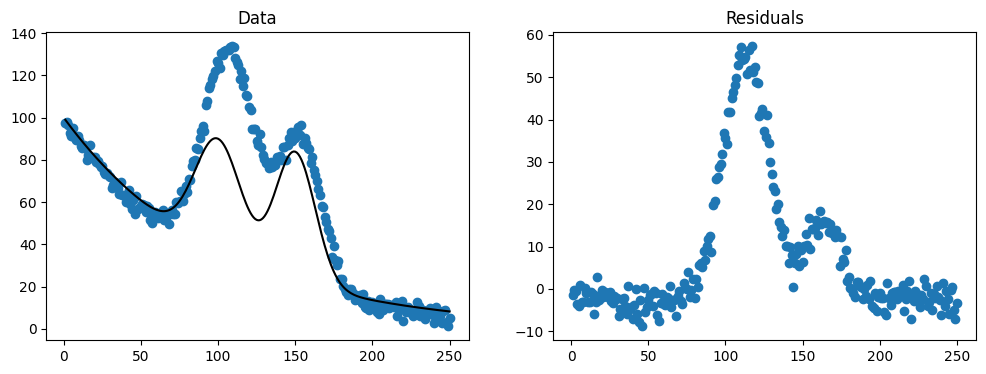

None
['x']
<bound method Model.set_param_hint of Model(exponential, prefix='c0_')>
['c0_amplitude', 'c0_decay']

Parameters fit values:
Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0     99.02     -inf      inf   0.5375     True     None     None
c0_decay_0         90.95     -inf      inf    1.103     True     None     None
c1_amplitude_0      4258     -inf      inf    42.38     True     None     None
c1_center_0          107     -inf      inf   0.1501     True     None     None
c1_sigma_0         16.67     -inf      inf   0.1605     True     None     None
c2_amplitude_0      2493     -inf      inf    36.17     True     None     None
c2_center_0        153.3     -inf      inf   0.1947     True     None     None
c2_sigma_0         13.81     -inf      inf   0.1868     True     None     None
Chi2 1.24752821e+03


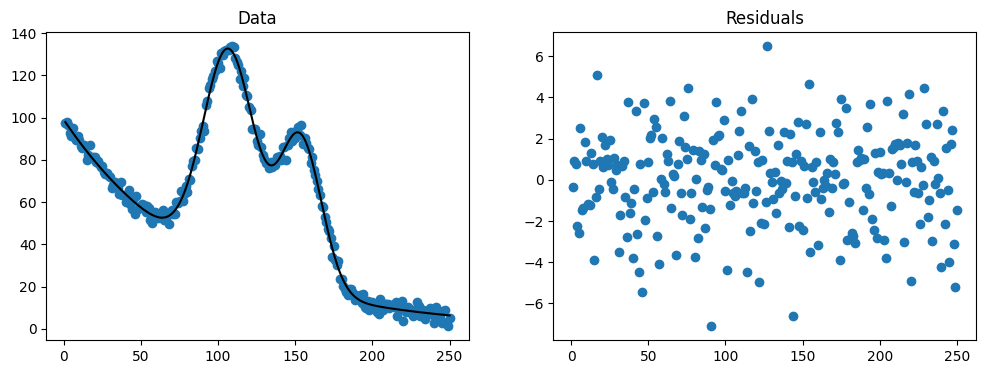

In [5]:
"""
# --- Here, how THEORY  function can be define
# --- And the initial PARAMETER values
# --- The parameter attribute definitions are:
# value (float): Numerical Parameter value (default is 0)
# vary (bool): Whether the Parameter is varied during a fit (default is True).
# min (float): Lower bound for value (default is -numpy.inf, no lower bound).
# max (float): Upper bound for value (default is +numpy.inf, no upper bound).
# expr (str): Mathematical expression used to constrain the value during the fit (default is '')
"""

theory_func_lst = [
    {
        'func_name': exponential,
        'init_params' : {
            'amplitude': {'value':100.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'decay': {'value':100, },
        },
        'fixed_opts': {}   # <-- non-fit option
    },
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':100, },
            'sigma': {'value':15, },
        },
        'fixed_opts': {}   # <-- non-fit option
    },
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':150, },
            'sigma': {'value':13, },
        },
        'fixed_opts': {}   # <-- non-fit option
    },
]

function_block = {
    'theory': theory_func_lst,
    'theory_connectors': ['+', '+',],
}

"""
# --- The `theory_connectors` (list of str): 
    A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
    the theory functions listed in 'theory'. Each operator connects one function to the next 
    in left-to-right order. For example, ['+', '*'] means: theory[0] + theory[1] * theory[2].

    The number of connectors must be exactly one less than the number of theory functions.
    The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
"""

dpath='./data'  # data path

# --- Load data (skip header) ---
file='NIST_Gauss2.dat' # data
file=os.path.join(
    dpath,
    file
)

dat = np.loadtxt(file)
x = dat[:, 1]
y = dat[:, 0]

xx = np.column_stack([x, x])
xy = np.column_stack([x, y])
yy = np.column_stack([y, y])

# data_block = {
#     'data_x': x,
#     'data_y': y
# }
# data_block = {
#     'data_x': xx,
#     'data_y': yy
# }

data_block = {
    'xy': xy,
    'xrange': None
    }


ITEMS = {
    'data': data_block,
    'functions': function_block,
}

LG = LmfitGlobal(ITEMS)

LG.ny
print(LG.data_xrange)

LG.ydat

# LG.prefix_on = True
# LG.prefix_on, LG._prefix_on

# LG.nc, LG.prefix_on, LG._prefix_on
# LG.func_lst, LG.funcname_lst, LG.independent_vars


lm = LG.model_list[0]
print(lm.independent_vars)
print(lm.set_param_hint)
print(lm._param_names)

lm.func
lm.param_names
# LG.extra_model_lst_kwargs
lm.param_hints

# LG._initial_params
# LG.prefix_list
# LG.func_list

# LG._minimize()

LG.fit()

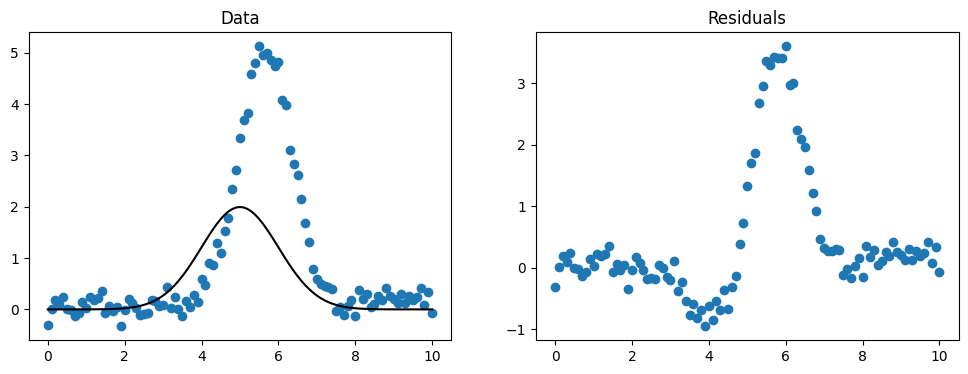

None
['x']
<bound method Model.set_param_hint of Model(gaussian)>
['amplitude', 'center', 'sigma']

Parameters fit values:
Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0      8.88     -inf      inf   0.1136     True     None     None
center_0        5.659     -inf      inf   0.0103     True     None     None
sigma_0        0.6977     -inf      inf  0.01031     True     None     None
Chi2 3.40883599e+00


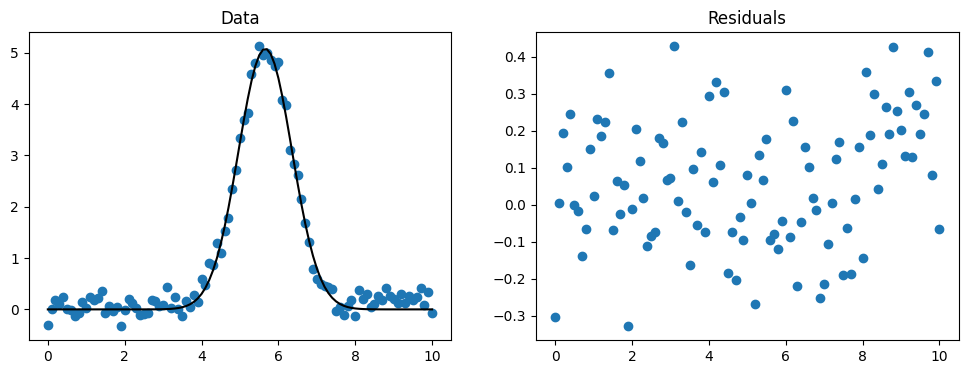

R^2 Score: 0.9853334774466996


In [6]:
"""
# --- Here, how THEORY  function can be define
# --- And the initial PARAMETER values
# --- The parameter attribute definitions are:
# value (float): Numerical Parameter value (default is 0)
# vary (bool): Whether the Parameter is varied during a fit (default is True).
# min (float): Lower bound for value (default is -numpy.inf, no lower bound).
# max (float): Upper bound for value (default is +numpy.inf, no upper bound).
# expr (str): Mathematical expression used to constrain the value during the fit (default is '')
"""

theory_func_lst = [
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':5.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':5, },
            'sigma': {'value':1, },
        },
        'fixed_opts': {}   # <-- non-fit option
    },
]

function_block = {
    'theory': theory_func_lst,
    'theory_connectors': [],
}
"""
# --- The `theory_connectors` (list of str): 
    A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
    the theory functions listed in 'theory'. Each operator connects one function to the next 
    in left-to-right order. For example, ['+', '*'] means: theory[0] + theory[1] * theory[2].

    The number of connectors must be exactly one less than the number of theory functions.
    The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
"""

dpath='./data'  # data path

# --- Load data (skip header) ---
file='model1d_gauss.dat' # data
file=os.path.join(
    dpath,
    file
)

dat = np.loadtxt(file)
x = dat[:, 0]
y = dat[:, 1]

xx = np.column_stack([x, x])
xy = np.column_stack([x, y])
yy = np.column_stack([y, y])

# data_block = {
#     'data_x': x,
#     'data_y': y
# }
# data_block = {
#     'data_x': xx,
#     'data_y': yy
# }

data_block = {
    'xy': xy,
    'xrange': None
    }


ITEMS = {
    'data': data_block,
    'functions': function_block,
}

LG = LmfitGlobal(ITEMS)

LG.ny
print(LG.data_xrange)

LG.ydat

# LG.prefix_on = True
# LG.prefix_on, LG._prefix_on

# LG.nc, LG.prefix_on, LG._prefix_on
# LG.func_lst, LG.funcname_lst, LG.independent_vars


lm = LG.model_list[0]
print(lm.independent_vars)
print(lm.set_param_hint)
print(lm._param_names)

lm.func
lm.param_names
# LG.extra_model_lst_kwargs
lm.param_hints

# LG._initial_params
# LG.prefix_list
# LG.func_list

# LG._minimize()

LG.fit()
import sklearn as skl
score = skl.metrics.r2_score(LG.ydat, LG.y_sim, multioutput='variance_weighted')
print("R^2 Score:", score)

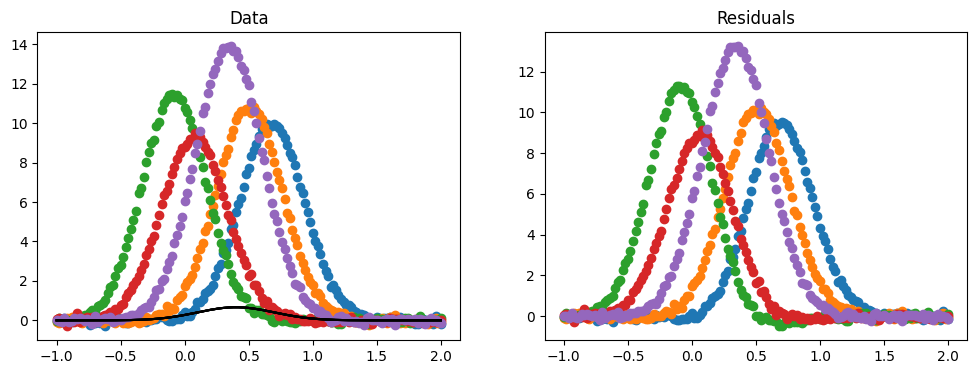

None
['x']
<bound method Model.set_param_hint of Model(gaussian)>
['amplitude', 'center', 'sigma']

Parameters fit values:
Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0     6.368        0      200   0.0162     True     None     None
amplitude_1     6.987        0      200  0.01629     True     None     None
amplitude_2     7.209        0      200  0.01609     True     None     None
amplitude_3     6.028        0      200  0.01633     True     None     None
amplitude_4     9.176        0      200  0.01647     True     None     None
center_0       0.6803       -2        2 0.0007474     True     None     None
center_1       0.5045       -2        2 0.0006925     True     None     None
center_2     -0.08261       -2        2 0.0006463     True     None     None
center_3      0.07383       -2        2 0.0008092     True     None     None
center_4        0.344       -2        2 0.0005451     True     None     None
sigma_0        0.2544     0.01    

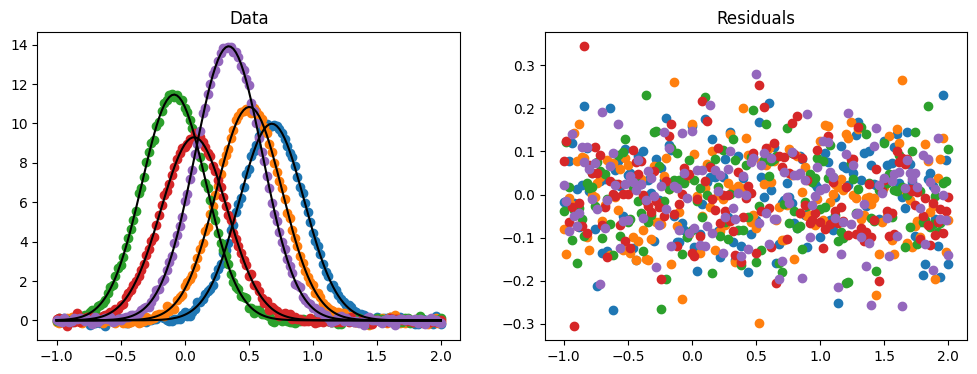

[0.99904698 0.99919206 0.9993335  0.99901252 0.99954565]
0.9992261428645449
0.999283835117725


In [7]:
"""
# --- Here, how THEORY  function can be define
# --- And the initial PARAMETER values
# --- The parameter attribute definitions are:
# value (float): Numerical Parameter value (default is 0)
# vary (bool): Whether the Parameter is varied during a fit (default is True).
# min (float): Lower bound for value (default is -numpy.inf, no lower bound).
# max (float): Upper bound for value (default is +numpy.inf, no upper bound).
# expr (str): Mathematical expression used to constrain the value during the fit (default is '')
"""

theory_func_lst = [
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':0.5, 'vary':True, 'min':0, 'max':200},
            'center': {'value':0.4, 'vary':True, 'min':-2, 'max':+2},
            'sigma': {'value':0.3, 'vary':True, 'min':0.01, 'max':3.0},
        },
        'fixed_opts': {}   # <-- non-fit option
    },
]

function_block = {
    'theory': theory_func_lst,
    'theory_connectors': [],
}
"""
# --- The `theory_connectors` (list of str): 
    A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
    the theory functions listed in 'theory'. Each operator connects one function to the next 
    in left-to-right order. For example, ['+', '*'] means: theory[0] + theory[1] * theory[2].

    The number of connectors must be exactly one less than the number of theory functions.
    The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
"""

# --- create raw data
# number of points per dataset
numpoints = 151
# number of datasets
ndata = 5

# xy will hold x plus ndata columns of y
xy = np.zeros((numpoints, ndata+1))

# reproducibility
np.random.seed(2021)

# x grid
x = np.linspace(-1, 2, numpoints)
xy[:, 0] = x

for i in range(ndata):
    amplitude = 0.60 + 9.50*np.random.rand()
    center = -0.20 + 1.20*np.random.rand()
    sigma = 0.25 + 0.03*np.random.rand()

    dat = gaussian(x, amplitude, center, sigma) \
          + np.random.normal(scale=0.1, size=x.size)

    xy[:, i+1] = dat


xy

data_block = {
    'xy': xy,
    'xrange': None
    }


ITEMS = {
    'data': data_block,
    'functions': function_block,
}

LG = LmfitGlobal(ITEMS)

LG.ny
print(LG.data_xrange)

LG.ydat

# LG.prefix_on = True
# LG.prefix_on, LG._prefix_on

# LG.nc, LG.prefix_on, LG._prefix_on
# LG.func_lst, LG.funcname_lst, LG.independent_vars


lm = LG.model_list[0]
print(lm.independent_vars)
print(lm.set_param_hint)
print(lm._param_names)

lm.func
lm.param_names
# LG.extra_model_lst_kwargs
lm.param_hints

# LG._initial_params
# LG.prefix_list
# LG.func_list

# LG._minimize()

LG.fit()
import sklearn as skl
# score = skl.metrics.r2_score(LG.ydat, LG.y_sim, multioutput='variance_weighted')
# print("R^2 Score:", score)
# score = skl.metrics.r2_score(LG.ydat, LG.y_sim, multioutput='variance_weighted')
# print("R^2 Score:", score)
# r2_scores = []
# for i in range(LG.ydat.shape[1]):
#     score = skl.metrics.r2_score(LG.ydat[:, i], LG.y_sim[:, i])
#     r2_scores.append(score)
#     print(f"Dataset {i+1}: R^2 = {score:.4f}")

print(skl.metrics.r2_score(LG.ydat, LG.y_sim, multioutput='raw_values'))
print(skl.metrics.r2_score(LG.ydat, LG.y_sim, multioutput='uniform_average'))
print(skl.metrics.r2_score(LG.ydat, LG.y_sim, multioutput='variance_weighted'))

In [8]:
import sklearn as skl

def r2_multioutput(y_true, y_pred, multioutput='uniform_average'):
    """:math:`R^2` (coefficient of determination) regression score function.

    Best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). In the general case when the true y is
    non-constant, a constant model that always predicts the average y
    disregarding the input features would get a :math:`R^2` score of 0.0.

    Parameters
    ----------
    y_true : ndarray-like of shape (n_samples,) or (n_samples, n_outputs).
             True/Correct/Experimental data
    y_pred : ndarray-like of shape (n_samples,) or (n_samples, n_outputs).
             Estimated/Target/Predicted values.
    multioutput : {'raw_values', 'uniform_average', 'variance_weighted'}
            Defines aggregating of multiple output scores. Default='uniform_average'.

            'raw_values' :
                Returns a full set of scores in case of multioutput input.

            'uniform_average' :
                Scores of all outputs are averaged with uniform weight.

            'variance_weighted' :
                Scores of all outputs are averaged, weighted by the variances
                of each individual output.

    Returns
    -------
    z : float or ndarray of floats
        The :math:`R^2` score or ndarray of scores if 'multioutput' is
        'raw_values'.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # residual sum of squares per output
    ss_res = np.sum((y_true - y_pred) ** 2, axis=0)
    # total sum of squares per output
    ss_tot = np.sum((y_true - np.mean(y_true, axis=0)) ** 2, axis=0)

    # per-output R^2
    r2_scores = 1 - ss_res / ss_tot

    if multioutput == 'raw_values':
        return r2_scores
    elif multioutput == 'uniform_average':
        return np.mean(r2_scores)
    elif multioutput == 'variance_weighted':
        weights = ss_tot / np.sum(ss_tot)
        return np.sum(weights * r2_scores)
    else:
        raise ValueError("Invalid multioutput option")


print(r2_multioutput(LG.ydat, LG.y_sim, multioutput='raw_values'))
print(r2_multioutput(LG.ydat, LG.y_sim, multioutput='uniform_average'))
print(r2_multioutput(LG.ydat, LG.y_sim, multioutput='variance_weighted'))

LG.y_sim.shape[1]

[0.99904698 0.99919206 0.9993335  0.99901252 0.99954565]
0.9992261428645449
0.9992838351177251


5

In [9]:
import numpy as np

y_true = np.array([[np.nan, 2],
                   [2, 3],
                   [3, 4]])
y_pred = np.array([[1.0, 2.0],
                   [2.1, 3.0],
                   [3.0, 4.1]])

mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
print(mask)
# [[False  True]
#  [ True  True]
#  [ True  True]]

y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

print(y_true_clean)  # [2. 3. 3. 4.]
print(y_pred_clean)  # [2. 2.1 3. 4.1]

[[False  True]
 [ True  True]
 [ True  True]]
[2. 2. 3. 3. 4.]
[2.  2.1 3.  3.  4.1]


In [10]:
import numpy as np

y_true = np.array([[np.nan, 2],
                   [2, 3],
                   [3, 4]])
y_pred = np.array([[1.0, 2.0],
                   [2.1, 3.0],
                   [3.0, 4.1]])

mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
print(mask)

[[False  True]
 [ True  True]
 [ True  True]]


In [11]:
def _r2_score(y_true, y_pred, multioutput='uniform_average'):
    """:math:`R^2` (coefficient of determination) regression score function.

    Best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). In the general case when the true y is
    non-constant, a constant model that always predicts the average y
    disregarding the input features would get a :math:`R^2` score of 0.0.

    Parameters
    ----------
    y_true : ndarray-like of shape (n_samples,) or (n_samples, n_outputs).
             True/Correct/Experimental data
    y_pred : ndarray-like of shape (n_samples,) or (n_samples, n_outputs).
             Estimated/Target/Predicted values.
    multioutput : {'raw_values', 'uniform_average', 'variance_weighted'}
            Defines aggregating of multiple output scores. Default='uniform_average'.

            'raw_values' :
                Returns a full set of scores in case of multioutput input.

            'uniform_average' :
                Scores of all outputs are averaged with uniform weight.

            'variance_weighted' :
                Scores of all outputs are averaged, weighted by the variances
                of each individual output.

    Returns
    -------
    z : float or ndarray of floats
        The :math:`R^2` score or ndarray of scores if 'multioutput' is
        'raw_values'.
    """
    def r_square_nan(y, f):
        """
        Calculate the R² statistic.

        Parameters:
        y (array-like): Array of observed data.
        f (array-like): Array of fitted data (model predictions).

        Returns:
        float: R² statistic.
        """

        # Convert inputs to numpy arrays if they aren't already
        y = np.array(y)
        f = np.array(f)

        # Mask to ignore NaN values
        mask = ~np.isnan(y)

        # Calculate the mean of the observed data, ignoring NaNs
        y_mean = np.mean(y[mask])

        # Compute the numerator (sum of squares of residuals)
        ss_res = np.sum((y[mask] - f[mask]) ** 2)

        # Compute the denominator (total sum of squares)
        ss_tot = np.sum((y[mask] - y_mean) ** 2)

        # Calculate R²
        r_squared = 1 - (ss_res / ss_tot)

        return r_squared
    
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.ndim==1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)

    if y_true.ndim != 2 or y_pred.ndim != 2:
        raise ValueError(f'`y_true` and `y_pred` must be 2-D after reshaping')
    if y_true.ndim != y_pred.ndim:
        raise ValueError(
            f'Shape mismatch: `y_true` has ndim={y_true.ndim}, '
            f'`y_pred` has ndim={y_pred.ndim}'
        )
    
    r2_scores = []
    for i in range(y_true.shape[1]):
        r2 = r_square_nan(y_true[:, i], y_pred[:, i])
        r2_scores.append(r2)


    if multioutput == 'raw_values':
        return r2_scores
    elif multioutput == 'uniform_average':
        return np.mean(r2_scores)
    # elif multioutput == 'variance_weighted':
    #     weights = ss_tot / np.sum(ss_tot)
    #     return np.sum(weights * r2_scores)
    else:
        raise ValueError("Invalid multioutput option")
        
    


y_pred_clean.shape
y_pred_clean.reshape(-1, 1)     # shape (4,1)

np.asarray(y_pred_clean).reshape(-1, 1) 


array([[2. ],
       [2.1],
       [3. ],
       [3. ],
       [4.1]])

In [12]:
import numpy as np

def _r2_score(y_true, y_pred, multioutput='uniform_average'):
    """
    R^2 (coefficient of determination) regression score function with NaN handling.
    """

    def r_square_nan(y, f):
        """Calculate R² for a single output, ignoring NaNs."""
        y = np.array(y)
        f = np.array(f)
        # Mask to ignore NaN values
        mask = ~np.isnan(y)
        # mask = ~np.isnan(y) & ~np.isnan(f)

        y_mean = np.mean(y[mask])
        ss_res = np.sum((y[mask] - f[mask]) ** 2)
        ss_tot = np.sum((y[mask] - y_mean) ** 2)

        r_squared = 1 - (ss_res / ss_tot)
        return r_squared, ss_tot

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Normalize to 2-D
    if y_true.ndim==1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)

    if y_true.ndim != 2 or y_pred.ndim != 2:
        raise ValueError(f'`y_true` and `y_pred` must be 2-D after reshaping')
    if y_true.ndim != y_pred.ndim:
        raise ValueError(
            f'Shape mismatch: `y_true` has ndim={y_true.ndim}, '
            f'`y_pred` has ndim={y_pred.ndim}'
        )

    r2_scores = []
    ss_tot_list = []

    # Compute per-output R^2 and ss_tot
    for i in range(y_true.shape[1]):
        r2, ss_tot = r_square_nan(y_true[:, i], y_pred[:, i])
        r2_scores.append(r2)
        ss_tot_list.append(ss_tot)

    r2_scores = np.array(r2_scores)
    ss_tot_list = np.array(ss_tot_list)

    if multioutput == 'raw_values':
        return r2_scores
    elif multioutput == 'uniform_average':
        return np.mean(r2_scores)
    elif multioutput == 'variance_weighted':
        weights = ss_tot_list / np.sum(ss_tot_list)
        return np.sum(weights * r2_scores)
    else:
        raise ValueError("Invalid multioutput option")
    

print(_r2_score(LG.ydat, LG.y_sim, multioutput='raw_values'))
print(_r2_score(LG.ydat, LG.y_sim, multioutput='uniform_average'))
print(_r2_score(LG.ydat, LG.y_sim, multioutput='variance_weighted'))

[0.99904698 0.99919206 0.9993335  0.99901252 0.99954565]
0.9992261428645449
0.9992838351177251


In [13]:
row_mask = ~np.isnan(y_true).any(axis=1) & ~np.isnan(y_pred).any(axis=1)
y_true = y_true[row_mask]
y_pred = y_pred[row_mask]
y_true

array([[2., 3.],
       [3., 4.]])

In [14]:
# np.atleast_2d(np.asarray(x)).shape
# np.atleast_2d(x).shape
# x, np.atleast_2d(x)

def ensure_column(arr):
    """
    Ensure array is always shape (N, M), and 1D becomes (N, 1).
    """
    arr = np.asarray(arr)
    
    # Make it 2D
    arr = np.atleast_2d(arr)
    
    # If row vector → convert to column vector
    if arr.shape[0] == 1 and arr.ndim == 2:
        arr = arr.T

    return arr

def ensure_2darray(arr):
    """Ensure array is always shape (N, M), and 1D becomes (N, 1).

    Args:
        arr (list): Numpy array in 1 dimension or list or list of lists

    Returns:
        numpy.array: 2d array of shape(N,M)
    """
    arr = np.asarray(arr)
    
    # Make it 2D
    arr = np.atleast_2d(arr)
    
    # If row vector → convert to column vector
    if arr.shape[0] == 1 and arr.ndim == 2:
        arr = arr.T

    return arr

def pad_array_with_nan(arr):
    """Pads a list of lists with NaN to ensure all inner lists have the same length.

    Args:
        arr (list): list of list of float or int

    Returns:
        numpy.ndarray: 2D array with shorter rows padded with np.nan
    """
    max_len = max(len(row) for row in arr)
    pad_arr = np.full((len(arr), max_len), np.nan)
    for i, row in enumerate(arr):
        pad_arr[i, :len(row)] = row
    return pad_arr

def pad_list_with_nan(lst):
    """
    Pads a list of lists with NaN to ensure all inner lists have the same length.

    Args:
        arr (lst): List of lists of float or int.

    Returns:
        numpy.ndarray: 2D array with shorter rows padded with np.nan.
                    If all rows are the same length, returns the array as-is.
    """
    row_lengths = [len(row) for row in lst]
    if len(set(row_lengths)) == 1:
        # All rows have the same length — no padding needed
        return np.array(lst, dtype=float)

    max_len = max(row_lengths)
    pad_arr = np.full((len(lst), max_len), np.nan)
    for i, row in enumerate(lst):
        pad_arr[i, :len(row)] = row
    return pad_arr

def merge_xyerr_data_numpy(xdat_lst, ydat_lst, yerr_lst=None):
    """
    Merges multiple (x, y, yerr) datasets into a unified NumPy array with shared x-axis.
    Missing values are filled with np.nan. If yerr_lst is None, error columns are omitted.

    Args:
        xdat_lst (list of np.ndarray): List of x arrays.
        ydat_lst (list of np.ndarray): List of y arrays.
        yerr_lst (list of np.ndarray or None): List of error arrays or None.

    Returns:
        np.ndarray: 2D array with columns: x, y_1, yerr_1, y_2, yerr_2, ...
    """
    all_x = np.unique(np.concatenate(xdat_lst))
    N = len(xdat_lst)

    y_merged = np.full((len(all_x), N), np.nan)
    yerr_merged = None if yerr_lst is None else np.full((len(all_x), N), np.nan)

    for i in range(N):
        x = xdat_lst[i]
        y = ydat_lst[i]
        for xi, yi in zip(x, y):
            idx = np.where(all_x == xi)[0]
            if idx.size > 0:
                y_merged[idx[0], i] = yi
        if yerr_lst is not None:
            for xi, ei in zip(x, yerr_lst[i]):
                idx = np.where(all_x == xi)[0]
                if idx.size > 0:
                    yerr_merged[idx[0], i] = ei

    # Stack into final output: [x | y_1 | yerr_1 | y_2 | yerr_2 | ...]
    if yerr_lst is not None:
        combined = [all_x.reshape(-1, 1)]
        for i in range(N):
            combined.append(y_merged[:, i].reshape(-1, 1))
            combined.append(yerr_merged[:, i].reshape(-1, 1))
        return np.hstack(combined)
    else:
        return np.column_stack((all_x, y_merged))
    
xxx = [
    [0, 1, 2],
    [0],
    [0, 1],
]

pad_list_with_nan(xxx)

print(ensure_2darray(y).shape)
ensure_2darray(y)

xy = np.column_stack([y, y])

xy, ensure_2darray(xy)

xxx = [
    [0,1, 2],
    [0,1,2]
]


xdat_lst = ensure_2darray(xx)
ydat_lst = ensure_2darray(yy)

print(xdat_lst.shape)

data = merge_xyerr_data_numpy(xdat_lst, ydat_lst, yerr_lst=None)

data.shape

data
xdat_lst

all_x = np.unique(np.concatenate(xdat_lst))
N = len(xdat_lst)

print(N)

y_merged = np.full((len(all_x), N), np.nan)

y_merged.shape

# [len(row) for row in xxx]

(101, 1)
(101, 2)
101


(101, 101)

In [15]:
# _forbidden_args = ('data', 'weights', 'params')
# _invalid_ivar = "Invalid independent variable name ('%s') for function %s"
# _invalid_par = "Invalid parameter name ('%s') for function %s"
# _invalid_hint = "unknown parameter hint '%s' for param '%s'"
# _hint_names = ('value', 'vary', 'min', 'max', 'expr')
# valid_forms = ()

# def _strip_prefix(name, self._prefix):
#     npref = len(self._prefix)
#     if npref > 0 and name.startswith(self._prefix):
#         name = name[npref:]
#     return name

# def _parse_params(func, opts, self._prefix=None):
#     """Build parameters from function arguments."""
#     if self.func is None:
#         return
    
#     self._param_root_names = None
#     self.independent_vars = None

#     kw_args = {}
#     keywords_ = None
#     indep_vars = []
#     default_vals = {}
#     # need to fetch the following from the function signature:
#     #   pos_args: list of positional argument names
#     #   kw_args: dict of keyword arguments with default values
#     #   keywords_:  name of **kws argument or None
#     # 1. limited support for asteval functions as the model functions:
#     if hasattr(self.func, 'argnames') and hasattr(self.func, 'kwargs'):
#         pos_args = self.func.argnames[:]
#         default_vals = {v: inspect._empty for v in pos_args}
#         for name, defval in self.func.kwargs:
#             kw_args[name] = defval
#             default_vals[name] = defval
#     # 2. modern, best-practice approach: use inspect.signature
#     else:
#         pos_args = []
#         sig = inspect.signature(self.func)
#         for fnam, fpar in sig.parameters.items():
#             if fpar.kind == fpar.VAR_KEYWORD:
#                 keywords_ = fnam
#             elif fpar.kind in (fpar.KEYWORD_ONLY,
#                                 fpar.POSITIONAL_OR_KEYWORD):
#                 default_vals[fnam] = fpar.default
#                 if (isinstance(fpar.default, (float, int, complex))
#                     and not isinstance(fpar.default, bool)):
#                     kw_args[fnam] = fpar.default
#                     pos_args.append(fnam)
#                 elif fpar.default == fpar.empty:
#                     pos_args.append(fnam)
#                 else:
#                     kw_args[fnam] = fpar.default
#                     indep_vars.append(fnam)
#             elif fpar.kind == fpar.POSITIONAL_ONLY:
#                 raise ValueError("positional only arguments with '/' are not supported")
#             elif fpar.kind == fpar.VAR_POSITIONAL:
#                 raise ValueError(f"varargs '*{fnam}' is not supported")
#     # inspection done

#     self._func_haskeywords = keywords_ is not None
#     self._func_allargs = list(default_vals.keys())
#     for key in kw_args:
#         if key not in self._func_allargs:
#             self._func_allargs.append(key)

#     if len(self._func_allargs) == 0 and keywords_ is not None:
#         return

#     self.independent_vars_defvals = {}
#     # default independent_var = 1st argument
#     if self.independent_vars is None:
#         self.independent_vars = [pos_args.pop(0)]
#         # default values for independent variables
#         for vnam in indep_vars:
#             dval = default_vals[vnam]
#             if vnam in self.opts:
#                 dval = self.opts[vnam]
#             self.independent_vars_defvals[vnam] = dval
#             if vnam not in self.independent_vars:
#                 self.independent_vars.append(vnam)

#     # default param names: all positional args
#     # except independent variables
#     self.def_vals = {}
#     might_be_param = []
#     if self._param_root_names is None:
#         self._param_root_names = []
#         for pname in pos_args:
#             if pname not in self.independent_vars:
#                 self._param_root_names.append(pname)
#         for key, val in kw_args.items():
#             if (not isinstance(val, bool) and
#                     isinstance(val, (float, int))):
#                 if key not in self._param_root_names:
#                     self._param_root_names.append(key)
#                 self.def_vals[key] = val
#             elif val is None:
#                 might_be_param.append(key)
#         for p in self.independent_vars:
#             if p in self._param_root_names:
#                 self._param_root_names.remove(p)

#     new_opts = {}
#     for opt, val in self.opts.items():
#         if (opt in self._param_root_names or opt in might_be_param and
#                 isinstance(val, Parameter)):
#             self.set_param_hint(opt, value=val.value,
#                                 min=val.min, max=val.max, expr=val.expr)
#         elif opt in self._func_allargs:
#             new_opts[opt] = val
#     self.opts = new_opts

#     if self._prefix is None:
#         self._prefix = ''
#     names = [f"{self._prefix}{pname}" for pname in self._param_root_names]

#     # check variables names for validity
#     # The implicit magic in fit() requires us to disallow some
#     fname = self.func.__name__
#     for arg in self.independent_vars:
#         if arg not in self._func_allargs or arg in self._forbidden_args:
#             raise ValueError(self._invalid_ivar % (arg, fname))
#     for arg in names:
#         if (self._strip_prefix(arg, self._prefix) not in self._func_allargs or
#                 arg in self._forbidden_args):
#             raise ValueError(self._invalid_par % (arg, fname))
#     # the following as been changed from OrderedSet for the time being.
#     self._param_names = names[:]
#     return self._param_names

# def set_param_hint(name, _prefix=None, self.param_hints={}, **kwargs):
#     """Set *hints* to use when creating parameters with `make_params()`.

#     The given hint can include optional bounds and constraints
#     ``(value, vary, min, max, expr)``, which will be used by
#     `Model.make_params()` when building default parameters.

#     While this can be used to set initial values, `Model.make_params` or
#     the function `create_params` should be preferred for creating
#     parameters with initial values.

#     # The intended use here is to control how a Model should create
#     # parameters, such as setting bounds that are required by the mathematics
#     # of the model (for example, that a peak width cannot be negative), or to
#     # define common constrained parameters.

    # Parameters
    # ----------
    # name : str
    #     Parameter name, can include the models `prefix` or not.
    # **kwargs : optional
    #     Arbitrary keyword arguments, needs to be a Parameter attribute.
    #     Can be any of the following:

    #     - value : float, optional
    #         Numerical Parameter value.
    #     - vary : bool, optional
    #         Whether the Parameter is varied during a fit (default is
    #         True).
    #     - min : float, optional
    #         Lower bound for value (default is ``-numpy.inf``, no lower
    #         bound).
    #     - max : float, optional
    #         Upper bound for value (default is ``numpy.inf``, no upper
    #         bound).
    #     - expr : str, optional
    #         Mathematical expression used to constrain the value during
    #         the fit.

    # Example
    # --------
    # >>> model = GaussianModel()
    # >>> model.set_param_hint('sigma', min=0)

    # """
    # npref = len(self._prefix)
    # if npref > 0 and name.startswith(self._prefix):
    #     name = name[npref:]

    # if name not in self.param_hints:
    #     self.param_hints[name] = {}

    # for key, val in kwargs.items():
    #     if key in self._hint_names:
    #         self.param_hints[name][key] = val
    #     else:
    #         warnings.warn(self._invalid_hint % (key, name))

    # return self.param_hints

In [16]:
_forbidden_args = ('data', 'weights', 'params')
_invalid_ivar = "Invalid independent variable name ('%s') for function %s"
_invalid_par = "Invalid parameter name ('%s') for function %s"
_invalid_hint = "unknown parameter hint '%s' for param '%s'"
_hint_names = ('value', 'vary', 'min', 'max', 'expr')
valid_forms = ()

def _strip_prefix(name, _prefix):
    npref = len(_prefix)
    if npref > 0 and name.startswith(_prefix):
        name = name[npref:]
    return name

def set_param_hint(name, _prefix=None, param_hints={}, **kwargs):
    """Set *hints* to use when creating parameters with `make_params()`.

    The given hint can include optional bounds and constraints
    ``(value, vary, min, max, expr)``, which will be used by
    `Model.make_params()` when building default parameters.

    While this can be used to set initial values, `Model.make_params` or
    the function `create_params` should be preferred for creating
    parameters with initial values.

    The intended use here is to control how a Model should create
    parameters, such as setting bounds that are required by the mathematics
    of the model (for example, that a peak width cannot be negative), or to
    define common constrained parameters.

    Parameters
    ----------
    name : str
        Parameter name, can include the models `prefix` or not.
    **kwargs : optional
        Arbitrary keyword arguments, needs to be a Parameter attribute.
        Can be any of the following:

        - value : float, optional
            Numerical Parameter value.
        - vary : bool, optional
            Whether the Parameter is varied during a fit (default is
            True).
        - min : float, optional
            Lower bound for value (default is ``-numpy.inf``, no lower
            bound).
        - max : float, optional
            Upper bound for value (default is ``numpy.inf``, no upper
            bound).
        - expr : str, optional
            Mathematical expression used to constrain the value during
            the fit.

    Example
    --------
    >>> model = GaussianModel()
    >>> model.set_param_hint('sigma', min=0)

    """
    npref = len(_prefix)
    if npref > 0 and name.startswith(_prefix):
        name = name[npref:]

    if name not in param_hints:
        param_hints[name] = {}

    for key, val in kwargs.items():
        if key in _hint_names:
            param_hints[name][key] = val
        else:
            warnings.warn(_invalid_hint % (key, name))

    return param_hints

def _parse_params(func, opts, independent_vars=None, _prefix=None):
    """Build parameters from function arguments."""
    if func is None:
        return
    
    _param_root_names = None
    # independent_vars = None

    kw_args = {}
    keywords_ = None
    indep_vars = []
    default_vals = {}
    # need to fetch the following from the function signature:
    #   pos_args: list of positional argument names
    #   kw_args: dict of keyword arguments with default values
    #   keywords_:  name of **kws argument or None
    # 1. limited support for asteval functions as the model functions:
    if hasattr(func, 'argnames') and hasattr(func, 'kwargs'):
        pos_args = func.argnames[:]
        default_vals = {v: inspect._empty for v in pos_args}
        for name, defval in func.kwargs:
            kw_args[name] = defval
            default_vals[name] = defval
    # 2. modern, best-practice approach: use inspect.signature
    else:
        pos_args = []
        sig = inspect.signature(func)
        for fnam, fpar in sig.parameters.items():
            if fpar.kind == fpar.VAR_KEYWORD:
                keywords_ = fnam
            elif fpar.kind in (fpar.KEYWORD_ONLY,
                                fpar.POSITIONAL_OR_KEYWORD):
                default_vals[fnam] = fpar.default
                if (isinstance(fpar.default, (float, int, complex))
                    and not isinstance(fpar.default, bool)):
                    kw_args[fnam] = fpar.default
                    pos_args.append(fnam)
                elif fpar.default == fpar.empty:
                    pos_args.append(fnam)
                else:
                    kw_args[fnam] = fpar.default
                    indep_vars.append(fnam)
            elif fpar.kind == fpar.POSITIONAL_ONLY:
                raise ValueError("positional only arguments with '/' are not supported")
            elif fpar.kind == fpar.VAR_POSITIONAL:
                raise ValueError(f"varargs '*{fnam}' is not supported")
    # inspection done
    print('pos_args =', pos_args)
    print('kw_args =', kw_args)

    _func_haskeywords = keywords_ is not None
    _func_allargs = list(default_vals.keys())
    print('_func_allargs=', _func_allargs)
    for key in kw_args:
        if key not in _func_allargs:
            _func_allargs.append(key)

    if len(_func_allargs) == 0 and keywords_ is not None:
        return

    independent_vars_defvals = {}
    # default independent_var = 1st argument
    if independent_vars is None:
        independent_vars = [pos_args.pop(0)]
        # default values for independent variables
        for vnam in indep_vars:
            dval = default_vals[vnam]
            if vnam in opts:
                dval = opts[vnam]
            independent_vars_defvals[vnam] = dval
            if vnam not in independent_vars:
                independent_vars.append(vnam)

    # default param names: all positional args
    # except independent variables
    def_vals = {}
    might_be_param = []
    if _param_root_names is None:
        _param_root_names = []
        for pname in pos_args:
            if pname not in independent_vars:
                _param_root_names.append(pname)
        for key, val in kw_args.items():
            if (not isinstance(val, bool) and
                    isinstance(val, (float, int))):
                if key not in _param_root_names:
                    _param_root_names.append(key)
                def_vals[key] = val
            elif val is None:
                might_be_param.append(key)
        for p in independent_vars:
            if p in _param_root_names:
                _param_root_names.remove(p)

    new_opts = {}
    print('_param_root_names =', _param_root_names)
    print('might_be_param =', might_be_param)
    for opt, val in opts.items():
        if (opt in _param_root_names or opt in might_be_param and
                isinstance(val, lmfit.Parameter)):
            set_param_hint(opt, value=val.value,
                                min=val.min, max=val.max, expr=val.expr)
        elif opt in _func_allargs:
            new_opts[opt] = val
    opts = new_opts
    print('new_opts =', new_opts)

    if _prefix is None:
        _prefix = ''
    names = [f"{_prefix}{pname}" for pname in _param_root_names]

    # check variables names for validity
    # The implicit magic in fit() requires us to disallow some
    fname = func.__name__
    for arg in independent_vars:
        if arg not in _func_allargs or arg in _forbidden_args:
            raise ValueError(_invalid_ivar % (arg, fname))
    for arg in names:
        if (_strip_prefix(arg, _prefix) not in _func_allargs or
                arg in _forbidden_args):
            raise ValueError(_invalid_par % (arg, fname))
    # the following as been changed from OrderedSet for the time being.
    _param_names = names[:]
    print('independent_vars =', independent_vars)
    print('_param_names =', _param_names)
    return _param_names


func=gaussian
func=exponential
func=step

opts={
    # 'form': 'erf'
}
independent_vars = ['x', 'form']
_parse_params(func, opts, independent_vars, _prefix=None)

pos_args = ['x', 'amplitude', 'center', 'sigma']
kw_args = {'amplitude': 1.0, 'center': 0.0, 'sigma': 1.0, 'form': 'linear'}
_func_allargs= ['x', 'amplitude', 'center', 'sigma', 'form']
_param_root_names = ['amplitude', 'center', 'sigma']
might_be_param = []
new_opts = {}
independent_vars = ['x', 'form']
_param_names = ['amplitude', 'center', 'sigma']


['amplitude', 'center', 'sigma']

In [17]:
inspect.signature(func).parameters.items()


lm = lmfit.Model(
    step, 
    prefix='c0_',
    form='erf'
    )

print(lm.independent_vars)
print(lm.set_param_hint)
print(lm._param_names)

['x', 'form']
<bound method Model.set_param_hint of Model(step, prefix='c0_', form='erf')>
['c0_amplitude', 'c0_center', 'c0_sigma']


In [18]:
lm = lmfit.Model(
    voigt, 
    prefix='c1_',
    gamma=None
    )

print(lm.independent_vars)
print(lm.set_param_hint)
print(lm._param_names)

['x', 'gamma']
<bound method Model.set_param_hint of Model(voigt, prefix='c1_', gamma='None')>
['c1_amplitude', 'c1_center', 'c1_sigma']


In [19]:
theory_func_lst = [
    {
        'func_name': step,
        'init_params' : {
            'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':100, },
            'sigma': {'value':10, },
        },
    },
    {
        'func_name': voigt,
        'init_params' : {
            'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
            'center': {'value':150, },
            'sigma': {'value':10, },
        },
    },
]

In [20]:
theory_func_lst = [
    {
        'func_name': step,
        'init_params': {
            'amplitude': {'value':2000.0, 'vary':True},
            'center': {'value':100},
            'sigma': {'value':10},
        },
        'fixed_opts': {'form': 'erf'}   # <-- non-fit option
    },
    {
        'func_name': voigt,
        'init_params': {
            'amplitude': {'value':2000.0, 'vary':True},
            'center': {'value':150},
            'sigma': {'value':10},
        },
        'fixed_opts': {'gamma': 5.0}    # <-- non-fit option
    },
]



def set_fixed_opts(func_entry, **new_opts):
    """
    Update fixed (non-fit) options for a theory function entry.

    Parameters
    ----------
    func_entry : dict
        A dictionary entry from theory_func_lst with keys:
        'func_name', 'init_params', 'fixed_opts'.
    new_opts : keyword arguments
        New fixed options to override (e.g. form='linear', gamma=10.0).

    Returns
    -------
    dict
        Updated function entry with modified fixed_opts.
    """
    if 'fixed_opts' not in func_entry:
        func_entry['fixed_opts'] = {}

    for key, val in new_opts.items():
        func_entry['fixed_opts'][key] = val

    return func_entry

theory_func_lst[0] = set_fixed_opts(theory_func_lst[0], form='logistic')


import lmfit

models = []
for i, entry in enumerate(theory_func_lst):
    func = entry['func_name']
    init_params = entry['init_params']
    fixed_opts = entry.get('fixed_opts', {})

    # Tell lmfit which arguments are independent variables
    indep_vars = ['x'] + list(fixed_opts.keys())

    model = lmfit.Model(func, independent_vars=indep_vars, prefix=f'c{i}_')

    # Apply parameter hints for fit parameters
    for pname, hint in init_params.items():
        model.set_param_hint(pname, **hint)

    # Store the fixed options so we can pass them later
    model.fixed_opts = fixed_opts
    models.append(model)


models

lm = models[0]
print(lm.independent_vars)
print(lm.set_param_hint)
print(lm._param_names)

lm.fixed_opts
lm.param_hints
# lm.func
# lm.param_names

theory_func_lst

['x', 'form']
<bound method Model.set_param_hint of Model(step, prefix='c0_')>
['c0_amplitude', 'c0_center', 'c0_sigma']


[{'func_name': <function __main__.step(x, amplitude=1.0, center=0.0, sigma=1.0, form='linear')>,
  'init_params': {'amplitude': {'value': 2000.0, 'vary': True},
   'center': {'value': 100},
   'sigma': {'value': 10}},
  'fixed_opts': {'form': 'logistic'}},
 {'func_name': <function __main__.voigt(x, amplitude=1.0, center=0.0, sigma=1.0, gamma=None)>,
  'init_params': {'amplitude': {'value': 2000.0, 'vary': True},
   'center': {'value': 150},
   'sigma': {'value': 10}},
  'fixed_opts': {'gamma': 5.0}}]

In [21]:
fn_pars = list(inspect.signature(step).parameters.keys())
fn_pars

['x', 'amplitude', 'center', 'sigma', 'form']

In [22]:
# Get ordered function parameters
fn_pars = list(inspect.signature(step).parameters.keys())

# First parameter is the x variable name
xname = fn_pars[0]

# Remaining parameters
argnames = fn_pars[1:]


argnames

fn_pars[:1]

import functools as ft

def create_composite_model(model_lst, op_list):
    op_map = {
        '+': operator.add,
        '*': operator.mul,
        '-': operator.sub,
        '/': operator.truediv,
    }

    model = ft.reduce(
        lambda x, y: op_map[y[1]](x, y[0]),
        zip(model_lst[1:], op_list),
        model_lst[0]
    )
    return model

import lmfit

models = []
for i, entry in enumerate(theory_fun_clst):
    func = entry['func_name']
    init_params = entry['init_params']
    fixed_opts = entry.get('fixed_opts', {})

    # Tell lmfit which arguments are independent variables
    indep_vars = ['x'] + list(fixed_opts.keys())

    model = lmfit.Model(func, independent_vars=indep_vars, prefix=f'c{i}_')

    # Apply parameter hints for fit parameters
    for pname, hint in init_params.items():
        model.set_param_hint(pname, **hint)

    # Store the fixed options so we can pass them later
    model.fixed_opts = fixed_opts
    models.append(model)

models


import functools as ft
import operator

def create_composite_model(model_lst, op_list):
    """
    Create a composite model from a list of models and operators.

    Parameters
    ----------
    model_lst : list
        List of lmfit.Model objects (or callables).
    op_list : list
        List of operator symbols ('+', '-', '*', '/') of length len(model_lst)-1.

    Returns
    -------
    composite_model : lmfit.Model or callable
        Composite model built from the given models and operators.
    composite_expr : str
        String representation of the composite function.
    """
    op_map = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul,
        '/': operator.truediv,
    }

    # --- Build composite model ---
    composite_model = ft.reduce(
        lambda x, y: op_map[y[1]](x, y[0]),
        zip(model_lst[1:], op_list),
        model_lst[0]
    )

    # --- Build human-readable expression ---
    expr_parts = [
        model_lst[0].func.__name__ if hasattr(model_lst[0], "func") else str(model_lst[0])
    ]
    for op, mdl in zip(op_list, model_lst[1:]):
        name = mdl.func.__name__ if hasattr(mdl, "func") else str(mdl)
        expr_parts.append(f"{op} {name}")
    composite_expr = " ".join(expr_parts)


    return composite_model, composite_expr


def build_composite_model(model_lst, op_list):
    """
    Build a composite lmfit.Model from a list of models and operators.

    Parameters
    ----------
    model_lst : list of lmfit.Model
        Models to combine.
    op_list : list of str
        Operators ('+', '-', '*', '/') of length len(model_lst)-1.

    Returns
    -------
    composite_model : lmfit.Model
        Composite model object.
    """
    op_map = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul,
        '/': operator.truediv,
    }

    composite_model = ft.reduce(
        lambda x, y: op_map[y[1]](x, y[0]),
        zip(model_lst[1:], op_list),
        model_lst[0]
    )
    return composite_model

def composite_expression(model_lst, op_list):
    """
    Build a human-readable expression string for the composite model.

    Parameters
    ----------
    model_lst : list of lmfit.Model
        Models to describe.
    op_list : list of str
        Operators ('+', '-', '*', '/') of length len(model_lst)-1.

    Returns
    -------
    expr : str
        String representation of the composite function with arguments.
    """
    expr_parts = []
    for i, mdl in enumerate(model_lst):
        func = mdl.func
        sig = inspect.signature(func)
        args = [pname for pname in sig.parameters]
        arg_str = ", ".join(args)
        func_str = f"{func.__name__}({arg_str})"
        expr_parts.append(func_str)
        if i < len(op_list):
            expr_parts.append(op_list[i])
    return " ".join(expr_parts)



s = create_composite_model(models, ['+', '+'])
print(s[1])

models[0].func.__name__

expr_parts = [models[0].func.__name__ if hasattr(models[0], "name") else str(models[0])]
expr_parts


expr = composite_expression(models, ['+', '+'])

print_in_box(expr, '#', width=80)
print_in_box(expr)


NameError: name 'theory_fun_clst' is not defined